# Sea Ice Extent Timeseries
## **ECCO**

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.bb045f71e45446bc93a90986a035c3a6 Dashboard: /services/dask-gateway/clusters/staging.bb045f71e45446bc93a90986a035c3a6/status,Cluster Workers: 20 Cores: 40 Memory: 160.00 GiB


In [8]:
client.close()
cluster.close()

NameError: name 'client' is not defined

In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from fastjmd95 import jmd95numba

In [4]:
si = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/seaice.zarr'))

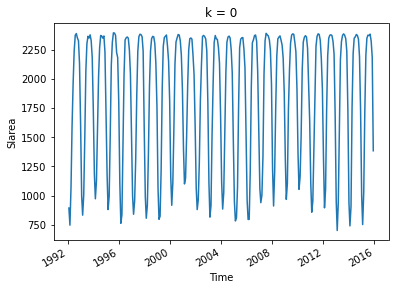

In [9]:
si.SIarea.sum(['i','j']).plot()

## SAM Index

In [10]:
url_ann = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/ann-seas-sam-57-07.csv'
ann_seas = pd.read_csv(url_ann, delim_whitespace=True, parse_dates=True, )
url_mo = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/mo-sam-57-07.csv'
mo = pd.read_csv(url_mo, delim_whitespace=True, parse_dates=True)

In [11]:
ann_seas.index = ann_seas.index.rename('time')
mo.index = mo.index.rename('time')

In [12]:
mo

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
time,,,,,,,,,,,,
1957-01-01,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958-01-01,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959-01-01,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960-01-01,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961-01-01,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018-01-01,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019-01-01,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78


In [13]:
#flattening dataframe by having next row go after the prev row, instead of col going after col
time = pd.date_range('1/1957', '1/2022', freq='M')
vector = np.array(mo.iloc[0])
for i in range(1,65):
    new_vec = np.array(mo.iloc[i])
    vector = np.append(vector,new_vec)

In [14]:
mo_xr = xr.DataArray(vector, coords=[time.rename('time')])

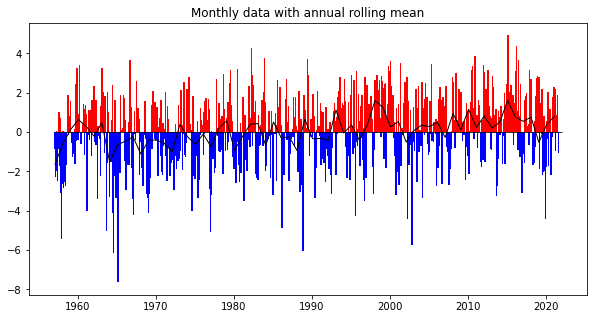

In [15]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.bar(time[np.where(mo_xr<0)], mo_xr.where(mo_xr < 0).dropna(dim='time'), color='b', width=70)
ax.bar(time[np.where(mo_xr>=0)], mo_xr.where(mo_xr >= 0).dropna(dim='time'), color='r', width=70)
ax.hlines(0, time[0], time[-1], colors='k', linewidth=0.8)
#mo_xr.rolling(time=12).mean().plot(color='k', linewidth=1)
plt.plot(time.values[np.arange(0, 780, 12)], mo_xr.groupby('time.year').mean().values, color='k', linewidth=1)
#mo_xr.groupby('time.year').mean().plot(color='k', linewidth=1)
plt.title('Monthly data with annual rolling mean');

## SAM & sea ice corr

In [17]:
si.SIarea.sum(['i', 'j'])

<xarray.DataArray 'SIarea' (time: 288)>
dask.array<sum-aggregate, shape=(288,), dtype=float32, chunksize=(72,), chunktype=numpy.ndarray>
Coordinates:
    k        int64 ...
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [24]:
ann_seas.ANN.loc['1992':'2016']

time
1992-01-01   -0.96
1993-01-01    3.28
1994-01-01   -0.29
1995-01-01    1.19
1996-01-01   -1.04
1997-01-01    1.16
1998-01-01    4.46
1999-01-01    3.67
2000-01-01    0.26
2001-01-01    1.57
2002-01-01   -1.32
2003-01-01    0.35
2004-01-01    1.17
2005-01-01    0.30
2006-01-01    1.51
2007-01-01   -0.77
2008-01-01    2.28
2009-01-01    0.22
2010-01-01    3.28
2011-01-01    0.79
2012-01-01    2.11
2013-01-01    0.30
2014-01-01    1.31
2015-01-01    4.13
2016-01-01    1.67
Name: ANN, dtype: float64

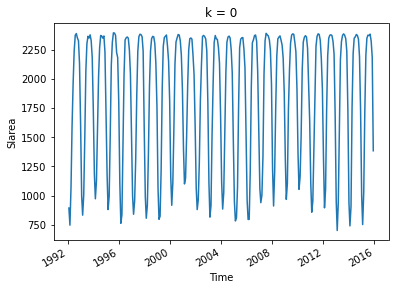

In [19]:
si.SIarea.sum(['i','j']).plot()

<AxesSubplot:xlabel='time'>

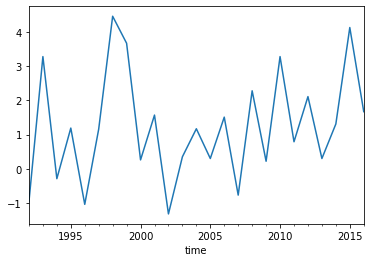

In [20]:
ann_seas.ANN.loc['1992':'2016'].plot()

In [21]:
ann_xr = ann_seas.ANN.to_xarray()

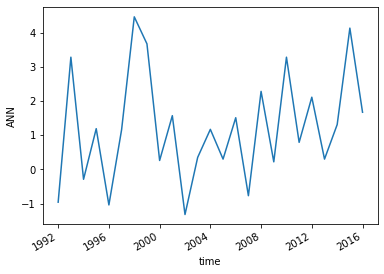

In [28]:
ann_xr.sel(time=slice('1992', '2016')).plot()

In [30]:
si.SIarea.sum(['i','j'])

<xarray.DataArray 'SIarea' (time: 288)>
dask.array<sum-aggregate, shape=(288,), dtype=float32, chunksize=(72,), chunktype=numpy.ndarray>
Coordinates:
    k        int64 ...
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [36]:
si.SIarea.sum(['i','j']).time

<xarray.DataArray 'time' (time: 288)>
array(['1992-01-15T00:00:00.000000000', '1992-02-13T00:00:00.000000000',
       '1992-03-15T00:00:00.000000000', ..., '2015-10-15T00:00:00.000000000',
       '2015-11-14T00:00:00.000000000', '2015-12-14T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    k        int64 ...
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [42]:
corr = xr.corr(si.SIarea.sum(['i','j']), mo_xr.sel(time=slice('1992', '2015')).interp(time=si.SIarea.time), dim='time').values
corr

array(-0.14877984)

### **ECCO's sea ice extent is weakly correlated with SAM index between 1992 through 2015**

## Saving Data

In [3]:
ice = xr.open_dataarray('sea-ice-ecco')

In [4]:
ice = ice.to_dataset()

In [5]:
ice

<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        int64 ...
Dimensions without coordinates: i, j
Data variables:
    SIarea   (time, j, i) float32 ...

In [6]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [7]:
#uploading seaice 
gcsmap_seaice = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/seaice.zarr')
ice.to_zarr(gcsmap_seaice, mode='w')